## Sentiment Analysis of Airline Reviews

In [49]:
#importing libraries
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

#import the dataset
df = pd.read_excel("Tweets.xlsx")

In [50]:
#display the first 5 rows of the data
df.head()

,airline,overall,author,review_date,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Turkish Airlines,7.0,Christopher Hackley,8th May 2019,âœ… Trip Verified | London to Izmir via Istanb...,NaN,Business,Economy Class,London to Izmir via Istanbul,2019-05-01 00:00:00,4.0,5.0,4.0,4.0,2.0,4.0,yes
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Turkish Airlines,2.0,Adriana Pisoi,7th May 2019,âœ… Trip Verified | Istanbul to Bucharest. We ...,NaN,Family Leisure,Economy Class,Istanbul to Bucharest,2019-05-01 00:00:00,4.0,1.0,1.0,1.0,1.0,1.0,no
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
#info about the columns in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131895 entries, 0 to 131894
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          65947 non-null  object 
 1   overall          64017 non-null  float64
 2   author           65947 non-null  object 
 3   review_date      65947 non-null  object 
 4   customer_review  65947 non-null  object 
 5   aircraft         19718 non-null  object 
 6   traveller_type   39755 non-null  object 
 7   cabin            63303 non-null  object 
 8   route            39726 non-null  object 
 9   date_flown       39633 non-null  object 
 10  seat_comfort     60681 non-null  float64
 11  cabin_service    60715 non-null  float64
 12  food_bev         52608 non-null  float64
 13  entertainment    44193 non-null  float64
 14  ground_service   39358 non-null  float64
 15  value_for_money  63975 non-null  float64
 16  recommended      64440 non-null  object 
dtypes: float64

# Data Pre-Processing

In [53]:
#finding the null values
df.isna().sum()

airline             65948
overall             67878
author              65948
review_date         65948
customer_review     65948
aircraft           112177
traveller_type      92140
cabin               68592
route               92169
date_flown          92262
seat_comfort        71214
cabin_service       71180
food_bev            79287
entertainment       87702
ground_service      92537
value_for_money     67920
recommended         67455
dtype: int64

In [54]:
#number of reviews in the dataset
n_reviews = df.shape[0]
print('Number of customer reviews in the dataset: {:d}'.format(n_reviews))

Number of customer reviews in the dataset: 131895


In [55]:
#A field in the customer review text
df['customer_review'][1]

'âœ… Trip Verified | London to Izmir via Istanbul. First time Iâ€™d flown TK. I found them very good in the air, cabin crew, planes, food, all very nice. Not so great on the ground, ground staff, call centre, computer systems. My flight from LHR was delayed so I missed the connection in Istanbul. Most ground staff donâ€™t speak English, and I was given contradictory instructions from those that could speak a little English. I eventually got on a flight to Izmir three hours later, but it wasnâ€™t an easy process, made worse by the vast distances one has to walk between gates in the cavernous new airport. Also, Iâ€™d phoned a TK call centre (based in Ukraine) to pay an extra Â£40 or so each way for extra leg room seats. However, as the departure times kept changing, my seats kept changing, and for the return leg to London from Istanbul I was not given an extra leg room seat. Luckily there was a spare exit row seat and the cabin crew sorted me out. Overall, I think their cabin crew and pl

In [56]:
#cleaning the customer review column
df['customer_review_clean'] = df['customer_review'].str.split('.',n=1,expand=True)[1]

In [57]:
# a field in the customer review text after cleaning the column
df['customer_review_clean'][1]

' First time Iâ€™d flown TK. I found them very good in the air, cabin crew, planes, food, all very nice. Not so great on the ground, ground staff, call centre, computer systems. My flight from LHR was delayed so I missed the connection in Istanbul. Most ground staff donâ€™t speak English, and I was given contradictory instructions from those that could speak a little English. I eventually got on a flight to Izmir three hours later, but it wasnâ€™t an easy process, made worse by the vast distances one has to walk between gates in the cavernous new airport. Also, Iâ€™d phoned a TK call centre (based in Ukraine) to pay an extra Â£40 or so each way for extra leg room seats. However, as the departure times kept changing, my seats kept changing, and for the return leg to London from Istanbul I was not given an extra leg room seat. Luckily there was a spare exit row seat and the cabin crew sorted me out. Overall, I think their cabin crew and planes are very good, ground staff and call centre 

In [58]:
#Extracting features required to solve the usecase
data = df[['customer_review_clean','overall','recommended']]
data.head()

,customer_review_clean,overall,recommended
0,NaN,NaN,NaN
1,First time Iâ€™d flown TK. I found them very ...,7.0,yes
2,NaN,NaN,NaN
3,"We make our check in in the airport, they Tak...",2.0,no
4,NaN,NaN,NaN


In [59]:
#number of null values in the dataset
data.isna().sum()

customer_review_clean    66024
overall                  67878
recommended              67455
dtype: int64

In [60]:
#finding the number of duplicate reviews
df_same_review_text = df.groupby('customer_review_clean')['customer_review_clean'].count().reset_index(name='n_reviews').sort_values(by='n_reviews',ascending=False)
df_same_review_text[df_same_review_text['n_reviews']>1]

,customer_review_clean,n_reviews
0,,84
56280,We flew regular Air Canada Toronto to Palm Be...,6
22988,I had no idea that it was Rouge until I compl...,6
33908,No leg room unless you upgrade your seat or a...,4
29967,Just to give less service. Had booked premium...,4
...,...,...
10651,Departed on time arrived good 20 min early. E...,2
10667,Departing at 9:45 pm. Crew managed to serve d...,2
15644,Flight time from HK to Bali changed twice pri...,2
15742,Flight was 2 hrs long. The only inflight ente...,2


In [61]:
#info about the columns extracted
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131895 entries, 0 to 131894
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_review_clean  65871 non-null  object 
 1   overall                64017 non-null  float64
 2   recommended            64440 non-null  object 
dtypes: float64(1), object(2)
memory usage: 3.0+ MB


In [62]:
#logic to derive sentiment from overall and recommended
from re import I
sentiment=[]
for i in range(len(data)):
  if data['recommended'][i]:
    if data['recommended'][i]=='yes':
      sentiment.append("positive")
    else:
      sentiment.append("negative")
  elif data['overall'][i]:
    if data['overall'][i]>5:
      sentiment.append("positive")
    else:
      sentiment.append("negative")
  else:
    sentiment.append("None")
print(len(sentiment), len(df['recommended']), len(df['overall']))

131895 131895 131895


In [63]:
# a glimpse of the data after adding the sentiment column
data['sentiment'] = sentiment
data.head()

<ipython-input-63-5444db629961>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'] = sentiment


,customer_review_clean,overall,recommended,sentiment
0,NaN,NaN,NaN,negative
1,First time Iâ€™d flown TK. I found them very ...,7.0,yes,positive
2,NaN,NaN,NaN,negative
3,"We make our check in in the airport, they Tak...",2.0,no,negative
4,NaN,NaN,NaN,negative


In [64]:
#finding how many times each review is repeated
df_same_review_text = df.groupby('customer_review_clean')['customer_review_clean'].count().reset_index(name='n_reviews').sort_values(by='n_reviews',ascending=False)
df_same_review_text[df_same_review_text['n_reviews']>1]

,customer_review_clean,n_reviews
0,,84
56280,We flew regular Air Canada Toronto to Palm Be...,6
22988,I had no idea that it was Rouge until I compl...,6
33908,No leg room unless you upgrade your seat or a...,4
29967,Just to give less service. Had booked premium...,4
...,...,...
10651,Departed on time arrived good 20 min early. E...,2
10667,Departing at 9:45 pm. Crew managed to serve d...,2
15644,Flight time from HK to Bali changed twice pri...,2
15742,Flight was 2 hrs long. The only inflight ente...,2


In [65]:
#dropping the duplicates
df_no_duplicates = data.drop_duplicates().copy()

In [66]:
data['sentiment'].value_counts()

negative    101349
positive     30546
Name: sentiment, dtype: int64

In [67]:
#copying the unique rows dataframe to df
df = df_no_duplicates.copy()

In [68]:
#checking the number of null values
df.isna().sum()

customer_review_clean      19
overall                  1776
recommended              1384
sentiment                   0
dtype: int64

In [69]:
#dropping the null values as they are of no use to us
df.dropna(inplace=True)

In [70]:
#shape of the dataset after preprocessing the data
df.shape

(57910, 4)

In [71]:
#extracting the columns from dataset required to analysing the sentiment
tweet_df = df[['customer_review_clean', 'sentiment']]
tweet_df.columns = ['review','sentiment']

In [72]:
#first 5 rows of the dataset
tweet_df.head()

,review,sentiment
1,First time Iâ€™d flown TK. I found them very ...,positive
3,"We make our check in in the airport, they Tak...",negative
5,I flew with this company several times in the...,negative
7,Turkish Airlines has consistently maintained ...,positive
9,Never book Turkish airlines if you are travel...,negative


In [73]:
#number of negative reviews and positive reviews
hist = pd.DataFrame(tweet_df["sentiment"].value_counts())
hist.head()

,sentiment
negative,29486
positive,28424


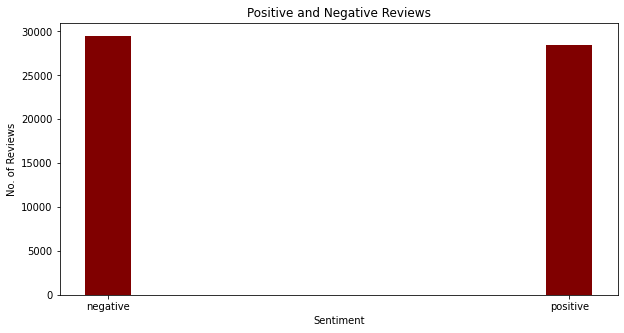

In [74]:
#Bar Plot of positive and negative reviews
import matplotlib.pyplot as plt
import numpy as np
data = {'C':20, 'C++':15, 'Java':30,
        'Python':35}
courses = hist.index
values = hist['sentiment']
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.1)
 
plt.xlabel("Sentiment")
plt.ylabel("No. of Reviews")
plt.title("Positive and Negative Reviews")
plt.show()

# Text Classification


In [ ]:
#encoding the sentiment label column
sentiment_label = tweet_df.sentiment.factorize()
sentiment_label

(array([0, 1, 1, ..., 1, 1, 1]),
 Index(['positive', 'negative'], dtype='object'))

In [ ]:
#tokenzing the data, encoding into sequences and padding the sequences
tweet = tweet_df.review.values
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweet)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(tweet)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [ ]:
#Tranformed data using tokenizer
print(tokenizer.word_index)

{'the': 1, 'to': 2, 'and': 3, 'was': 4, 'a': 5, 'i': 6, 'in': 7, 'flight': 8, 'on': 9, 'of': 10, 'for': 11, 'with': 12, 'were': 13, 'we': 14, 'not': 15, 'that': 16, 'is': 17, 'my': 18, 'they': 19, 'it': 20, 'at': 21, 'but': 22, 'had': 23, 'this': 24, 'have': 25, 'no': 26, 'as': 27, 'very': 28, 'from': 29, 'service': 30, 'you': 31, 'time': 32, 'me': 33, 'be': 34, 'so': 35, 'our': 36, 'all': 37, 'are': 38, 'an': 39, 'food': 40, 'good': 41, 'seat': 42, 'seats': 43, 'there': 44, 'would': 45, 'staff': 46, 'crew': 47, 'when': 48, 'us': 49, 'one': 50, 'airline': 51, 'which': 52, 'flights': 53, 'only': 54, 'their': 55, 'plane': 56, 'or': 57, 'get': 58, 'again': 59, 'by': 60, 'hours': 61, 'cabin': 62, 'if': 63, 'check': 64, 'airport': 65, 'after': 66, 'out': 67, 'will': 68, 'them': 69, 'airlines': 70, 'class': 71, 'more': 72, 'even': 73, 'about': 74, 'up': 75, 'other': 76, 'fly': 77, 'first': 78, 'back': 79, 'could': 80, 'boarding': 81, 'than': 82, 'did': 83, 'hour': 84, '2': 85, 'business': 86

In [ ]:
# Tweet and the corresponding encoded doc
print(tweet[0])
print(encoded_docs[0])

 First time Iâ€™d flown TK. I found them very good in the air, cabin crew, planes, food, all very nice. Not so great on the ground, ground staff, call centre, computer systems. My flight from LHR was delayed so I missed the connection in Istanbul. Most ground staff donâ€™t speak English, and I was given contradictory instructions from those that could speak a little English. I eventually got on a flight to Izmir three hours later, but it wasnâ€™t an easy process, made worse by the vast distances one has to walk between gates in the cavernous new airport. Also, Iâ€™d phoned a TK call centre (based in Ukraine) to pay an extra Â£40 or so each way for extra leg room seats. However, as the departure times kept changing, my seats kept changing, and for the return leg to London from Istanbul I was not given an extra leg room seat. Luckily there was a spare exit row seat and the cabin crew sorted me out. Overall, I think their cabin crew and planes are very good, ground staff and call centre s

In [ ]:
#Text after parsing the data
print(padded_sequence[0])

[   0    0    0    0    0    0   78   32 3051  313 1964    6  237   69
   28   41    7    1   95   62   47  352   40   37   28  133   15   35
  108    9    1  214  214   46  271 1567 1444 1760   18    8   29  579
    4   98   35    6  341    1  320    7  649  184  214   46  787  616
  400    3    6    4  200 2013   29  471   16   80  616    5  204  400
    6  702  100    9    5    8    2  390   61  195   22   20 1480   39
  478  499  142  547   60    1 3403 4558   50  132    2  839  330 1053
    7    1  105   65  112 3051 3621    5 1964  271 1567 1097    7 3774
    2  134   39  173   57   35  303  123   11  173  138  190   43  158
   27    1  198  194  403 1373   18   43  403 1373    3   11    1  124
  138    2  374   29  649    6    4   15  200   39  173  138  190   42
 1226   44    4    5 1648  622  293   42    3    1   62   47 2687   33
   67  185    6  339   55   62   47    3  352   38   28   41  214   46
    3  271 1567   46  281  152 1881    3   19   37  281  152 1444 1760
    3 

# Data Modelling

In [ ]:
#creating a Recurrent Neural Network with an embedding layer, a LSTM layer, and a dense layer
embedding_vector_length = 32
#creating a sequential model
model = Sequential() 
#creating the embedding layer
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
#adding dropout layer to drop 25% of the data
model.add(SpatialDropout1D(0.25))
#creating a LSTM layer
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
#adding a dropout layer to drop out 20 percent data
model.add(Dropout(0.2))
#creating a dense layer with sigmoid activation function
model.add(Dense(1, activation='sigmoid'))
#compiling the model 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) 
#summary of the model 
print(model.summary()) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           1516000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 1,532,651
Trainable params: 1,532,651
Non-trainable params: 0
______________________________________________

In [ ]:
#fitting the training data
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=64)

Epoch 1/5
724/724 [==============================] - 213s 289ms/step - loss: 0.3508 - accuracy: 0.8418 - val_loss: 0.2071 - val_accuracy: 0.9232
Epoch 2/5
724/724 [==============================] - 214s 295ms/step - loss: 0.2546 - accuracy: 0.9026 - val_loss: 0.2124 - val_accuracy: 0.9192
Epoch 3/5
724/724 [==============================] - 213s 295ms/step - loss: 0.2327 - accuracy: 0.9110 - val_loss: 0.1975 - val_accuracy: 0.9258
Epoch 4/5
724/724 [==============================] - 212s 293ms/step - loss: 0.2206 - accuracy: 0.9152 - val_loss: 0.1959 - val_accuracy: 0.9260
Epoch 5/5
724/724 [==============================] - 214s 295ms/step - loss: 0.2153 - accuracy: 0.9171 - val_loss: 0.2064 - val_accuracy: 0.9248


# Model Evaluation

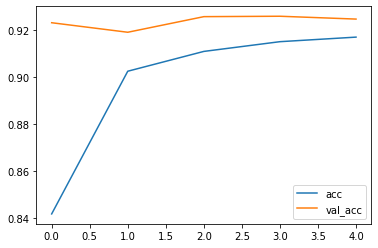

<Figure size 432x288 with 0 Axes>

In [ ]:
#plotting a graph for training accuracy and validation accuracy
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

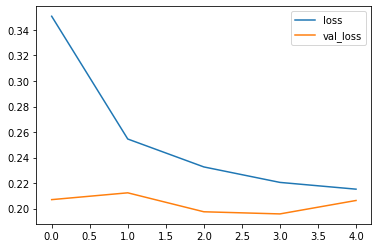

<Figure size 432x288 with 0 Axes>

In [ ]:
#plotting a graph for training loss and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

In [ ]:
#function to predict the sentiment for unknown data
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])

In [ ]:
#predicting the sentiment
test_sentence1 = "I enjoyed my journey on this flight."
predict_sentiment(test_sentence1)

test_sentence2 = "This is the worst flight experience of my life!"
predict_sentiment(test_sentence2)

1/1 [==============================] - 1s 850ms/step
Predicted label:  positive
1/1 [==============================] - 0s 79ms/step
Predicted label:  negative


# Deployment

In [ ]:
import pickle

In [ ]:
#taking a dump of model for deployment
pickle.dump(model, open('model.pkl','wb'))

In [ ]:
#loading the model
model2 = pickle.load(open('model.pkl','rb'))

In [ ]:
#taking a dump of the tokenizer
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#loading the tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
#testing if the model and tokenizer dumped are appropriate
def predict_sentiment_emotion(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model2.predict(tw).round().item())
    print(prediction)
    print("Predicted label: ", sentiment_label[1][prediction])


print(predict_sentiment_emotion("I enjoyed my journey on this flight."))
print(predict_sentiment_emotion("This is the worst flight experience of my life!"))

1/1 [==============================] - 0s 42ms/step
0
Predicted label:  positive
None
1/1 [==============================] - 0s 42ms/step
1
Predicted label:  negative
None


In [ ]:
# Code is continued further to deploy in a seperate file